## 1. Carga de Datos y Preprocesamiento Avanzado

En este primer paso, cargamos nuestro conjunto de datos limpio (`cleaned_train.csv`). Luego, aplicamos una serie de transformaciones y codificaciones avanzadas para preparar los datos para los modelos de Machine Learning. Estas acciones están basadas en los hallazgos del Análisis Exploratorio de Datos (EDA) para manejar distribuciones sesgadas, *outliers* y variables categóricas de forma efectiva. Finalmente, dividiremos los datos en conjuntos de entrenamiento y prueba.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
!pip install category_encoders # Install the missing library
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib # Para guardar modelos y transformadores

print("Librerías importadas exitosamente.")

# --- Cargar el Dataset ---
# Cargamos el archivo CSV que contiene nuestros datos limpios de entrenamiento.
df = pd.read_csv('../data/processed/cleaned_train.csv')
print("\nDataset de entrenamiento cargado exitosamente. Primeras 5 filas:")
print(df.head(4))

# --- Transformaciones Logarítmicas y Winsorización ---
# Aplicamos logaritmo (usando log1p para manejar posibles ceros) y winsorización
# a columnas numéricas clave para reducir el sesgo y manejar outliers.
columns_to_transform = ['price', 'milage', 'horsepower', 'car_age']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])
    # La winsorización se aplica para "tapar" los valores extremos (outliers).
    # Los límites (0.05, 0.05) significan que se cortan el 5% inferior y el 5% superior de los valores.
    df[col] = winsorize(df[col], limits=(0.05, 0.05))
print("\nTransformaciones logarítmicas y winsorización aplicadas a columnas especificadas.")

# --- Manejo de Multicolinealidad ---
# Eliminamos columnas identificadas en el EDA como redundantes o que causan multicolinealidad.
# 'model_year' está correlacionado con 'car_age', y 'engine_size_L' con 'horsepower'/'cylinders'.
df = df.drop(columns=['model_year', 'engine_size_L'], errors='ignore')
print("\nColumnas 'model_year' y 'engine_size_L' eliminadas para manejar multicolinealidad.")

# --- Codificación de Variables Categóricas ---
# **Target Encoding para 'brand':** Ideal para variables con muchas categorías.
# Reemplaza cada categoría con el promedio del valor objetivo (price) para esa categoría.
encoder_brand = ce.TargetEncoder(cols=['brand'])
df['brand'] = encoder_brand.fit_transform(df['brand'], df['price'])
print("\nTarget Encoding aplicado a la columna 'brand'.")

# **One-Hot Encoding para otras categóricas:** Para variables con menos categorías únicas.
# Identificamos las columnas que aún son de tipo 'object' (texto) y aplicamos One-Hot Encoding.
categorical_cols_ohe = df.select_dtypes(include='object').columns.tolist()

# Definimos nuestra variable objetivo (Y) y nuestras características (X).
# Y es 'price', X es el resto.
Y = df['price']
X = df.drop('price', axis=1)

# Usamos ColumnTransformer para aplicar One-Hot Encoding solo a las columnas categóricas en X.
# 'remainder=\'passthrough\'' asegura que las columnas numéricas no se vean afectadas.
if categorical_cols_ohe:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_ohe)
        ],
        remainder='passthrough'
    )
    X = preprocessor.fit_transform(X)
    print("\nOne-Hot Encoding aplicado a las columnas categóricas restantes en X.")
else:
    print("\nNo hay columnas categóricas adicionales para One-Hot Encoding.")

print("\nVariables objetivo (Y) y características (X) definidas y preparadas.")

# --- División de Datos en Entrenamiento y Prueba ---
# Dividimos los datos para entrenar el modelo con una parte y evaluarlo con datos no vistos.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("\nDatos divididos en conjuntos de entrenamiento (80%) y prueba (20%).")
print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}, y_test: {y_test.shape}")

Librerías importadas exitosamente.

Dataset de entrenamiento cargado exitosamente. Primeras 5 filas:
       brand  model_year  milage      fuel_type  \
0       MINI        2007  213000       Gasoline   
1    Lincoln        2002  143250       Gasoline   
2  Chevrolet        2002  136731  E85 Flex Fuel   
3    Genesis        2017   19500       Gasoline   

                                 accident clean_title  price  car_age  \
0                           None reported         Yes   4200       19   
1  At least 1 accident or damage reported         Yes   4999       24   
2                           None reported         Yes  13900       24   
3                           None reported         Yes  45000        9   

   horsepower  engine_size_L  cylinders transmission_simple  
0       172.0            1.6        4.0                  AT  
1       252.0            3.9        8.0                  AT  
2       320.0            5.3        8.0                  AT  
3       420.0            5.0 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                188533 non-null  float64
 1   milage               188533 non-null  float64
 2   fuel_type            188533 non-null  object 
 3   accident             188533 non-null  object 
 4   clean_title          188533 non-null  object 
 5   price                188533 non-null  float64
 6   car_age              188533 non-null  float64
 7   horsepower           188533 non-null  float64
 8   cylinders            188533 non-null  float64
 9   transmission_simple  188533 non-null  object 
dtypes: float64(6), object(4)
memory usage: 14.4+ MB


## 2. Entrenamiento y Evaluación del Modelo de Regresión Lineal

Comenzamos con un modelo simple de Regresión Lineal para establecer una línea base de rendimiento. Entrenaremos el modelo con los datos de entrenamiento y lo evaluaremos con los datos de prueba, utilizando métricas comunes para regresión: MAE (Error Absoluto Medio), MSE (Error Cuadrático Medio), RMSE (Raíz del Error Cuadrático Medio) y R² (Coeficiente de Determinación).

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Importando LinearRegression y métricas de evaluación.")

# Inicializamos el modelo de Regresión Lineal.
linear_model = LinearRegression()

print("\nEntrenando Modelo de Regresión Lineal...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
linear_model.fit(X_train, y_train)
print("Modelo de Regresión Lineal entrenado exitosamente.")

# --- Evaluación del Modelo de Regresión Lineal ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_linear = linear_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"\n--- Evaluación del Modelo de Regresión Lineal ---\n")
print(f"  Mean Absolute Error (MAE): {mae_linear:.4f}")
print(f"  Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_linear:.4f}")
print(f"  R-squared (R2): {r2_linear:.4f}")

# Almacenamos las métricas para comparaciones futuras.
metrics = {
    'Linear Regression': {
        'MAE': mae_linear,
        'MSE': mse_linear,
        'RMSE': rmse_linear,
        'R2': r2_linear
    }
}
print("Métricas de evaluación del modelo de Regresión Lineal almacenadas.")

Importando LinearRegression y métricas de evaluación.

Entrenando Modelo de Regresión Lineal...
Modelo de Regresión Lineal entrenado exitosamente.

--- Evaluación del Modelo de Regresión Lineal ---

  Mean Absolute Error (MAE): 0.3411
  Mean Squared Error (MSE): 0.1977
  Root Mean Squared Error (RMSE): 0.4446
  R-squared (R2): 0.6462
Métricas de evaluación del modelo de Regresión Lineal almacenadas.


## 3. Entrenamiento y Evaluación del Modelo Random Forest Regressor

Ahora, implementaremos un modelo más complejo y potente: el Random Forest Regressor. Este es un modelo de conjunto que combina múltiples árboles de decisión para mejorar la precisión y controlar el sobreajuste. Entrenaremos el modelo con los mismos datos preprocesados y evaluaremos su rendimiento para compararlo con la Regresión Lineal.

In [7]:
from sklearn.ensemble import RandomForestRegressor

print("Importando RandomForestRegressor.")

# Inicializamos el modelo Random Forest Regressor.
# Usamos 'random_state' para reproducibilidad y 'n_jobs=-1' para usar todos los núcleos del CPU.
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1)

print("\nEntrenando Random Forest Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
random_forest_model.fit(X_train, y_train)
print("Modelo Random Forest Regressor entrenado exitosamente.")

# --- Evaluación del Modelo Random Forest Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_rf = random_forest_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n--- Evaluación del Modelo Random Forest Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"  Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"  R-squared (R2): {r2_rf:.4f}")

# Almacenamos las métricas y mostramos la comparación entre ambos modelos.
metrics['Random Forest'] = {
    'MAE': mae_rf,
    'MSE': mse_rf,
    'RMSE': rmse_rf,
    'R2': r2_rf
}
print("Métricas de evaluación del Random Forest almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando RandomForestRegressor.

Entrenando Random Forest Regressor (esto puede tomar un tiempo)...
Modelo Random Forest Regressor entrenado exitosamente.

--- Evaluación del Modelo Random Forest Regressor ---

  Mean Absolute Error (MAE): 0.3282
  Mean Squared Error (MSE): 0.1898
  Root Mean Squared Error (RMSE): 0.4357
  R-squared (R2): 0.6603
Métricas de evaluación del Random Forest almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603


## 4. Entrenamiento y Evaluación del Modelo Gradient Boosting Regressor

Continuando con nuestra búsqueda del modelo más acertado, implementaremos el Gradient Boosting Regressor. Este es otro modelo de conjunto que construye árboles de decisión de forma secuencial, corrigiendo los errores de los árboles anteriores. Es conocido por su alto rendimiento y a menudo supera a otros algoritmos en tareas de regresión. Lo entrenaremos y evaluaremos para compararlo con los modelos ya analizados.

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

print("Importando GradientBoostingRegressor.")

# Inicializamos el modelo Gradient Boosting Regressor.
# Usamos 'random_state' para reproducibilidad.
# Los parámetros pueden ajustarse, pero para una primera pasada, usamos valores predeterminados razonables.
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

print("\nEntrenando Gradient Boosting Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
gradient_boosting_model.fit(X_train, y_train)
print("Modelo Gradient Boosting Regressor entrenado exitosamente.")

# --- Evaluación del Modelo Gradient Boosting Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_gb = gradient_boosting_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\n--- Evaluación del Modelo Gradient Boosting Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"  Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gb:.4f}")
print(f"  R-squared (R2): {r2_gb:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['Gradient Boosting'] = {
    'MAE': mae_gb,
    'MSE': mse_gb,
    'RMSE': rmse_gb,
    'R2': r2_gb
}
print("Métricas de evaluación del Gradient Boosting almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando GradientBoostingRegressor.

Entrenando Gradient Boosting Regressor (esto puede tomar un tiempo)...
Modelo Gradient Boosting Regressor entrenado exitosamente.

--- Evaluación del Modelo Gradient Boosting Regressor ---

  Mean Absolute Error (MAE): 0.3147
  Mean Squared Error (MSE): 0.1726
  Root Mean Squared Error (RMSE): 0.4154
  R-squared (R2): 0.6912
Métricas de evaluación del Gradient Boosting almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912


### 5. Entrenamiento y Evaluación del Modelo K-Nearest Neighbors (KNN) Regressor

Incluimos el modelo KNN Regressor, que predice el valor de una nueva instancia basándose en el promedio de los valores de sus k vecinos más cercanos en el espacio de características. Es un modelo simple y a menudo robusto. Lo entrenaremos y evaluaremos para compararlo con los modelos anteriores.

In [13]:
from sklearn.neighbors import KNeighborsRegressor

print("Importando KNeighborsRegressor.")

# Inicializamos el modelo KNN Regressor.
# Usamos un valor predeterminado para n_neighbors (k=5).
knn_model = KNeighborsRegressor(n_neighbors=5)

print("\nEntrenando KNN Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
knn_model.fit(X_train, y_train)
print("Modelo KNN Regressor entrenado exitosamente.")

# --- Evaluación del Modelo KNN Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_knn = knn_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"\n--- Evaluación del Modelo KNN Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"  Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_knn:.4f}")
print(f"  R-squared (R2): {r2_knn:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['KNN Regressor'] = {
    'MAE': mae_knn,
    'MSE': mse_knn,
    'RMSE': rmse_knn,
    'R2': r2_knn
}
print("Métricas de evaluación del KNN Regressor almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando KNeighborsRegressor.

Entrenando KNN Regressor (esto puede tomar un tiempo)...
Modelo KNN Regressor entrenado exitosamente.

--- Evaluación del Modelo KNN Regressor ---

  Mean Absolute Error (MAE): 0.3364
  Mean Squared Error (MSE): 0.1978
  Root Mean Squared Error (RMSE): 0.4448
  R-squared (R2): 0.6460
Métricas de evaluación del KNN Regressor almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460


## 6. Entrenamiento y Evaluación del Modelo Support Vector Regressor (SVR)

Incluiremos el Support Vector Regressor (SVR). Los SVR son modelos potentes que buscan encontrar una función que se desvíe en una cantidad máxima \( \epsilon \) del objetivo para todos los puntos de entrenamiento, al mismo tiempo que es lo más plana posible. Entrenaremos y evaluaremos SVR para una comparación exhaustiva con los demás modelos.

In [14]:
from sklearn.svm import SVR

print("Importando SVR.")

# Inicializamos el modelo SVR.
# SVR es computacionalmente intensivo, por lo que usaremos un subconjunto de datos
# para una ejecución más rápida si el dataset es muy grande, o un kernel lineal simple.
# Para una primera pasada, mantendremos los parámetros por defecto con un kernel 'rbf' y un dataset más pequeño si es necesario.
# Sin embargo, dado el tamaño de los datos (X_train.shape), SVR con el kernel 'rbf' por defecto
# podría tardar mucho o quedarse sin memoria. Usaremos un subconjunto de los datos.

# Definimos el tamaño del subconjunto (e.g., 10% del entrenamiento) para SVR
subset_size = 0.1 # Para pruebas rápidas, ajustar según la potencia de cálculo

# Creamos un subconjunto de los datos de entrenamiento
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=(1-subset_size), random_state=42
)

print(f"Entrenando SVR con un subconjunto de datos (tamaño: {X_train_subset.shape[0]} muestras)...")

# Inicializamos SVR. Usar kernel='linear' puede ser más rápido, o 'rbf' con un subset.
# Ajuste C y epsilon si es necesario.
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1) # Parámetros por defecto para empezar

# Entrenamos el modelo con el subconjunto de datos de entrenamiento.
# ¡ADVERTENCIA: SVR puede ser EXTREMADAMENTE lento con grandes conjuntos de datos y el kernel rbf por defecto!
# Si la ejecución tarda demasiado, considere reducir 'subset_size' o cambiar a kernel='linear'.
svr_model.fit(X_train_subset, y_train_subset)
print("Modelo SVR entrenado exitosamente con subconjunto de datos.")

# --- Evaluación del Modelo SVR ---
# Hacemos predicciones sobre el conjunto de prueba completo (X_test).
# Nota: El modelo se entrenó con un subconjunto, pero se evalúa con el test set completo.
y_pred_svr = svr_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"\n--- Evaluación del Modelo SVR ---\n")
print(f"  Mean Absolute Error (MAE): {mae_svr:.4f}")
print(f"  Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_svr:.4f}")
print(f"  R-squared (R2): {r2_svr:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['SVR'] = {
    'MAE': mae_svr,
    'MSE': mse_svr,
    'RMSE': rmse_svr,
    'R2': r2_svr
}
print("Métricas de evaluación del SVR almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Importando SVR.
Entrenando SVR con un subconjunto de datos (tamaño: 15082 muestras)...
Modelo SVR entrenado exitosamente con subconjunto de datos.

--- Evaluación del Modelo SVR ---

  Mean Absolute Error (MAE): 0.3295
  Mean Squared Error (MSE): 0.1873
  Root Mean Squared Error (RMSE): 0.4328
  R-squared (R2): 0.6648
Métricas de evaluación del SVR almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460
  ### SVR ###
    MAE: 0.3295
    MSE: 0.1873
    RMSE: 0.4328
    R2: 0.6648


## Entrenamiento y Evaluación del Modelo XGBoost Regressor

### Subtask:
Implementar un modelo XGBoost Regressor, entrenarlo con los datos de entrenamiento y evaluarlo con los datos de prueba, añadiendo sus métricas al diccionario `metrics` para una comparación completa.


In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Importando XGBRegressor y métricas de evaluación.")

# Inicializamos el modelo XGBoost Regressor.
# Usamos 'random_state' para reproducibilidad y 'n_jobs=-1' para usar todos los núcleos del CPU.
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

print("\nEntrenando XGBoost Regressor (esto puede tomar un tiempo)...")
# Entrenamos el modelo con nuestros datos de entrenamiento.
xgb_model.fit(X_train, y_train)
print("Modelo XGBoost Regressor entrenado exitosamente.")

# --- Evaluación del Modelo XGBoost Regressor ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_xgb = xgb_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n--- Evaluación del Modelo XGBoost Regressor ---\n")
print(f"  Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"  Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"  R-squared (R2): {r2_xgb:.4f}")

# Almacenamos las métricas y mostramos la comparación entre todos los modelos.
metrics['XGBoost'] = {
    'MAE': mae_xgb,
    'MSE': mse_xgb,
    'RMSE': rmse_xgb,
    'R2': r2_xgb
}
print("Métricas de evaluación del XGBoost almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")


Importando XGBRegressor y métricas de evaluación.

Entrenando XGBoost Regressor (esto puede tomar un tiempo)...
Modelo XGBoost Regressor entrenado exitosamente.

--- Evaluación del Modelo XGBoost Regressor ---

  Mean Absolute Error (MAE): 0.3075
  Mean Squared Error (MSE): 0.1672
  Root Mean Squared Error (RMSE): 0.4089
  R-squared (R2): 0.7008
Métricas de evaluación del XGBoost almacenadas.

--- Comparación Final de Métricas de Modelos ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460
  ### SVR ###
    MAE: 0.3295
    MSE: 0.1873
    RMSE: 0.4328
    R2: 0.6648
  ### XGBoost ###
    MAE: 0.3075
    MSE: 0.1672
    RMSE: 0.4089
    R2: 0.7008


## Actualización de la Comparación Final de Modelos y Conclusión


Revisar y actualizar la tabla comparativa de métricas de todos los modelos (incluyendo XGBoost) y la conclusión final para identificar el modelo más adecuado para el estudio, basándose en su rendimiento general (R2, MAE, RMSE).


In [27]:
import pandas as pd

print("\n--- Tabla Comparativa de Métricas de Modelos (Actualizada) ---")

# Convertimos el diccionario de métricas a un DataFrame para una mejor visualización
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df.index.name = 'Modelo'

display(metrics_df.round(4))

print("\n--- Conclusión sobre el Mejor Modelo (Actualizada) ---")
# Identificamos el modelo con el mejor R2 (el más alto) y el menor MAE/RMSE.
best_r2_model = metrics_df['R2'].idxmax()
best_r2_value = metrics_df['R2'].max()
best_mae_model = metrics_df['MAE'].idxmin()
best_mae_value = metrics_df['MAE'].min()

print(f"Basándonos en las métricas de evaluación actualizadas:")
print(f"  - El modelo con el R-squared (R2) más alto es: **{best_r2_model}** con un valor de {best_r2_value:.4f}")
print(f"  - El modelo con el Mean Absolute Error (MAE) más bajo es: **{best_mae_model}** con un valor de {best_mae_value:.4f}")

if best_r2_model == best_mae_model:
    print(f"\nPor lo tanto, el modelo **{best_r2_model}** es el más indicado para este estudio, ya que logra el mejor balance entre la varianza explicada (R2) y el menor error absoluto medio (MAE), así como el menor error cuadrático medio (RMSE).")
else:
    print(f"\nAunque el R2 más alto fue para {best_r2_model} y el MAE más bajo para {best_mae_model}, si consideramos el rendimiento general (R2, MAE y RMSE), el modelo **{best_mae_model}** sigue siendo la mejor elección para este estudio, ya que minimiza el error promedio.")

print("\nEste modelo será utilizado para futuras predicciones y despliegue.")


--- Tabla Comparativa de Métricas de Modelos (Actualizada) ---


,MAE,MSE,RMSE,R2
Modelo,,,,
Linear Regression,0.3411,0.1977,0.4446,0.6462
Random Forest,0.3282,0.1898,0.4357,0.6603
Gradient Boosting,0.3147,0.1726,0.4154,0.6912
KNN Regressor,0.3364,0.1978,0.4448,0.6460
SVR,0.3295,0.1873,0.4328,0.6648
XGBoost,0.3075,0.1672,0.4089,0.7008



--- Conclusión sobre el Mejor Modelo (Actualizada) ---
Basándonos en las métricas de evaluación actualizadas:
  - El modelo con el R-squared (R2) más alto es: **XGBoost** con un valor de 0.7008
  - El modelo con el Mean Absolute Error (MAE) más bajo es: **XGBoost** con un valor de 0.3075

Por lo tanto, el modelo **XGBoost** es el más indicado para este estudio, ya que logra el mejor balance entre la varianza explicada (R2) y el menor error absoluto medio (MAE), así como el menor error cuadrático medio (RMSE).

Este modelo será utilizado para futuras predicciones y despliegue.


## 9. Introducción a la Validación Cruzada y Ajuste de Hiperparámetros

La **validación cruzada** es una técnica esencial en el Machine Learning para evaluar de manera robusta el rendimiento de un modelo y garantizar que sus métricas de evaluación sean fiables y generalizables a datos no vistos. En lugar de dividir el conjunto de datos una única vez en entrenamiento y prueba, la validación cruzada divide los datos en múltiples subconjuntos. El modelo se entrena y evalúa repetidamente en diferentes combinaciones de estos subconjuntos. Esto ayuda a:

*   **Reducir el sesgo de la evaluación**: Al promediar los resultados de múltiples iteraciones, se obtiene una estimación más precisa del rendimiento del modelo, minimizando la dependencia de una única división aleatoria de los datos.
*   **Mitigar el sobreajuste**: Permite identificar si el modelo está aprendiendo patrones específicos del conjunto de entrenamiento en lugar de generalizar a nuevos datos, lo cual es crucial para evitar modelos que funcionan bien solo con los datos con los que fueron entrenados.
*   **Evaluar la generalización del modelo**: Proporciona una medida más confiable de cómo se comportará el modelo en el mundo real, donde se enfrentará a datos que nunca ha visto antes.

El **ajuste de hiperparámetros** es el proceso de optimizar los parámetros externos de un modelo, es decir, aquellos que no se aprenden directamente de los datos durante el entrenamiento, sino que se configuran antes de que el entrenamiento comience. Ejemplos de hiperparámetros incluyen la profundidad máxima de un árbol en un Random Forest, el número de vecinos en KNN o la tasa de aprendizaje en un Gradient Boosting. Un ajuste adecuado de estos hiperparámetros puede:

*   **Mejorar significativamente el rendimiento del modelo**: Un modelo con hiperparámetros bien ajustados puede alcanzar una mayor precisión, un menor error y una mejor capacidad de generalización.
*   **Evitar el sobreajuste o subajuste**: La elección correcta de los hiperparámetros es clave para encontrar el equilibrio perfecto entre un modelo demasiado simple (subajuste) o demasiado complejo (sobreajuste).
*   **Optimizar el tiempo de entrenamiento y la eficiencia**: Algunos hiperparámetros pueden influir en la velocidad de entrenamiento y la cantidad de recursos computacionales necesarios.

**Reasoning**:
The next step is to implement, train, and evaluate the XGBoost Regressor model as per the instructions. This involves importing the necessary class, initializing and training the model, making predictions, calculating evaluation metrics, and updating the shared metrics dictionary.



**Reasoning**:
The subtask requires updating the model comparison table and conclusion to include the newly trained XGBoost model. This involves converting the `metrics` dictionary into a pandas DataFrame, displaying it, identifying the best-performing model based on R2 and MAE, and then printing a revised conclusion.



## Validación Cruzada para el Modelo Óptimo

### Subtask:
Aplicar validación cruzada (K-Fold) al modelo identificado como el más óptimo (XGBoost Regressor).


**Reasoning**:
To perform K-Fold cross-validation on the optimal XGBoost model, I need to import `KFold` and `cross_val_score` from `sklearn.model_selection`.



In [28]:
from sklearn.model_selection import KFold, cross_val_score

print("Importando KFold y cross_val_score para validación cruzada.")

# Inicializamos KFold para la validación cruzada
# n_splits define el número de "folds" o divisiones del conjunto de datos.
# shuffle=True asegura que los datos se mezclan antes de dividirse, lo cual es importante si los datos tienen un orden.
# random_state asegura la reproducibilidad de la mezcla.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nAplicando validación cruzada (K-Fold con {kf.n_splits} splits) al modelo XGBoost...")

# Calculamos las puntuaciones de R-squared utilizando cross_val_score.
# 'scoring="r2"' especifica que la métrica a optimizar/evaluar es el coeficiente de determinación R-squared.
r2_scores_xgb = cross_val_score(xgb_model, X, Y, cv=kf, scoring='r2')

print("Validación cruzada completada.")

# Imprimimos la puntuación media de R-squared y su desviación estándar.
print(f"\n--- Resultados de la Validación Cruzada para XGBoost ---")
print(f"  Media de R-squared: {r2_scores_xgb.mean():.4f}")
print(f"  Desviación estándar de R-squared: {r2_scores_xgb.std():.4f}")

Importando KFold y cross_val_score para validación cruzada.

Aplicando validación cruzada (K-Fold con 5 splits) al modelo XGBoost...
Validación cruzada completada.

--- Resultados de la Validación Cruzada para XGBoost ---
  Media de R-squared: 0.7036
  Desviación estándar de R-squared: 0.0025


## Ajuste de Hiperparámetros con RandomizedSearchCV para el Modelo Óptimo

### Subtask:
Implementar RandomizedSearchCV para encontrar la combinación óptima de hiperparámetros para el modelo que ha sido identificado como el mejor (XGBoost).


**Reasoning**:
The subtask requires implementing `RandomizedSearchCV` to find the optimal hyperparameters for the XGBoost model. This involves defining a parameter distribution, initializing the search, fitting it to the training data, and then printing the best parameters and score. I will import `RandomizedSearchCV`, define the `param_dist` dictionary with common XGBoost hyperparameters and their distributions, instantiate `RandomizedSearchCV` with the `xgb_model` and specified parameters, fit it to `X_train` and `y_train`, and finally print the optimal hyperparameters and the best R2 score found.



In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("Importando RandomizedSearchCV y distribuciones para hiperparámetros.")

# --- 2. Definir un diccionario con las distribuciones de los hiperparámetros a explorar ---
# Se definen rangos o distribuciones para los hiperparámetros clave de XGBoost.
param_dist = {
    'n_estimators': randint(100, 1000),  # Número de árboles en el bosque
    'learning_rate': uniform(0.01, 0.2), # Tasa de aprendizaje
    'max_depth': randint(3, 10),         # Profundidad máxima de cada árbol
    'subsample': uniform(0.6, 0.4),      # Fracción de muestras para entrenar cada árbol
    'colsample_bytree': uniform(0.6, 0.4), # Fracción de características para entrenar cada árbol
    'gamma': uniform(0, 0.5),            # Mínima pérdida de reducción para hacer una partición
    'reg_alpha': uniform(0, 1),          # Regularización L1
    'reg_lambda': uniform(0, 1)          # Regularización L2
}

print("Distribuciones de hiperparámetros definidas para XGBoost.")

# --- 3. Instanciar RandomizedSearchCV ---
# n_iter: Número de combinaciones de hiperparámetros a probar.
# cv: Objeto KFold para la validación cruzada.
# scoring: Métrica a optimizar (R-squared en este caso).
# random_state: Para reproducibilidad.
# n_jobs: Para usar todos los núcleos del CPU disponibles.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50, # Se pueden ajustar las iteraciones para mayor exhaustividad o menor tiempo
    cv=kf, # Utilizando el objeto KFold ya definido
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("RandomizedSearchCV inicializado.")

# --- 4. Ajustar (fit) el objeto RandomizedSearchCV a los datos de entrenamiento ---
print("\nIniciando búsqueda aleatoria de hiperparámetros para XGBoost (esto puede tomar un tiempo)...")
random_search.fit(X_train, y_train)
print("Búsqueda aleatoria de hiperparámetros completada.")

# --- 5. Imprimir los mejores hiperparámetros y la mejor puntuación ---
print("\n--- Mejores Hiperparámetros encontrados para XGBoost ---")
print(random_search.best_params_)
print(f"\n--- Mejor puntuación R-squared obtenida (validación cruzada): {random_search.best_score_:.4f} ---")

Importando RandomizedSearchCV y distribuciones para hiperparámetros.
Distribuciones de hiperparámetros definidas para XGBoost.
RandomizedSearchCV inicializado.

Iniciando búsqueda aleatoria de hiperparámetros para XGBoost (esto puede tomar un tiempo)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda aleatoria de hiperparámetros completada.

--- Mejores Hiperparámetros encontrados para XGBoost ---
{'colsample_bytree': np.float64(0.6550083776583973), 'gamma': np.float64(0.17053317552512925), 'learning_rate': np.float64(0.032694704248117816), 'max_depth': 9, 'n_estimators': 514, 'reg_alpha': np.float64(0.877339353380981), 'reg_lambda': np.float64(0.2579416277151556), 'subsample': np.float64(0.8639936184136716)}

--- Mejor puntuación R-squared obtenida (validación cruzada): 0.7075 ---


## Evaluación del Modelo Óptimo con Hiperparámetros Ajustados

### Subtask:
Una vez encontrados los mejores hiperparámetros, se entrenará un nuevo modelo (el óptimo) con estos parámetros finales. Este modelo se evaluará en el conjunto de prueba (X_test, y_test) para obtener sus métricas (MAE, MSE, RMSE, R²), las cuales se añadirán al diccionario metrics para una comparación final y actualizada.


**Reasoning**:
The subtask requires training a new XGBoost model with the optimal hyperparameters found by `RandomizedSearchCV`, evaluating it, and updating the `metrics` dictionary. I will initialize `XGBRegressor` with `best_params_`, train it on `X_train` and `y_train`, predict on `X_test`, calculate evaluation metrics, add them to `metrics`, and then print the results.



In [30]:
print("Evaluando el modelo XGBoost óptimo con los hiperparámetros ajustados...")

# Obtener los mejores hiperparámetros del RandomizedSearchCV
best_params = random_search.best_params_

# Inicializar un nuevo modelo XGBoost con los hiperparámetros óptimos
# Aseguramos que n_jobs esté presente para usar todos los núcleos
optimized_xgb_model = XGBRegressor(random_state=42, n_jobs=-1, **best_params)

print("\nEntrenando el modelo XGBoost optimizado...")
# Entrenar el modelo optimizado
optimized_xgb_model.fit(X_train, y_train)
print("Modelo XGBoost optimizado entrenado exitosamente.")

# --- Evaluación del Modelo XGBoost Optimizado ---
# Hacemos predicciones sobre el conjunto de prueba.
y_pred_optimized_xgb = optimized_xgb_model.predict(X_test)

# Calculamos las métricas de evaluación.
mae_optimized_xgb = mean_absolute_error(y_test, y_pred_optimized_xgb)
mse_optimized_xgb = mean_squared_error(y_test, y_pred_optimized_xgb)
rmse_optimized_xgb = np.sqrt(mse_optimized_xgb)
r2_optimized_xgb = r2_score(y_test, y_pred_optimized_xgb)

print(f"\n--- Evaluación del Modelo XGBoost Optimizado ---\n")
print(f"  Mean Absolute Error (MAE): {mae_optimized_xgb:.4f}")
print(f"  Mean Squared Error (MSE): {mse_optimized_xgb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_optimized_xgb:.4f}")
print(f"  R-squared (R2): {r2_optimized_xgb:.4f}")

# Almacenamos las métricas en el diccionario `metrics`
metrics['XGBoost Optimized'] = {
    'MAE': mae_optimized_xgb,
    'MSE': mse_optimized_xgb,
    'RMSE': rmse_optimized_xgb,
    'R2': r2_optimized_xgb
}
print("Métricas de evaluación del XGBoost optimizado almacenadas.")

print("\n--- Comparación Final de Métricas de Modelos (Actualizada) ---")
for model_name, model_metrics in metrics.items():
    print(f"  ### {model_name} ###")
    for metric_name, value in model_metrics.items():
        print(f"    {metric_name}: {value:.4f}")

Evaluando el modelo XGBoost óptimo con los hiperparámetros ajustados...

Entrenando el modelo XGBoost optimizado...
Modelo XGBoost optimizado entrenado exitosamente.

--- Evaluación del Modelo XGBoost Optimizado ---

  Mean Absolute Error (MAE): 0.3056
  Mean Squared Error (MSE): 0.1648
  Root Mean Squared Error (RMSE): 0.4060
  R-squared (R2): 0.7050
Métricas de evaluación del XGBoost optimizado almacenadas.

--- Comparación Final de Métricas de Modelos (Actualizada) ---
  ### Linear Regression ###
    MAE: 0.3411
    MSE: 0.1977
    RMSE: 0.4446
    R2: 0.6462
  ### Random Forest ###
    MAE: 0.3282
    MSE: 0.1898
    RMSE: 0.4357
    R2: 0.6603
  ### Gradient Boosting ###
    MAE: 0.3147
    MSE: 0.1726
    RMSE: 0.4154
    R2: 0.6912
  ### KNN Regressor ###
    MAE: 0.3364
    MSE: 0.1978
    RMSE: 0.4448
    R2: 0.6460
  ### SVR ###
    MAE: 0.3295
    MSE: 0.1873
    RMSE: 0.4328
    R2: 0.6648
  ### XGBoost ###
    MAE: 0.3075
    MSE: 0.1672
    RMSE: 0.4089
    R2: 0.7008
  #

## Predicción de Precios en Datos de Prueba con el Modelo Óptimo Final

### Subtask:
Utilizar el modelo más óptimo y ajustado (XGBoost optimizado) para predecir precios en el conjunto de datos `cleaned_test.csv`. Se asegurará que todos los pasos de preprocesamiento sean consistentes y se revertirán las transformaciones logarítmicas para mostrar los precios en su escala original.


**Reasoning**:
The subtask requires using the optimized XGBoost model to predict prices on the `cleaned_test.csv` dataset. This involves applying the exact same preprocessing steps to the test data as were applied to the training data, making predictions, and then reverting the log transformation to get the original price scale.



In [ ]:
print("Cargando y preprocesando el archivo cleaned_test.csv para predicciones...")

# --- 1. Cargar el Dataset de Prueba --- (Mantendremos el df_test original para comparación)
df_original_test = pd.read_csv('../data/processed/cleaned_test.csv')
df_test = df_original_test.copy() # Creamos una copia para las transformaciones
print("\nDataset de prueba cargado exitosamente. Primeras 5 filas (original):")
print(df_test.head())

# --- 2. Aplicar las Mismas Transformaciones del Entrenamiento ---
# Columnas para transformación logarítmica y winsorización.
feature_columns_to_transform = ['milage', 'horsepower', 'car_age']

for col in feature_columns_to_transform:
    df_test[col] = np.log1p(df_test[col])
    df_test[col] = winsorize(df_test[col], limits=(0.05, 0.05)) # Aplicamos la misma winsorización.
print("\nLog transformación y winsorización aplicadas a las características del set de prueba.")

# --- 3. Eliminar columnas para consistencia ---
df_test = df_test.drop(columns=['model_year', 'engine_size_L'], errors='ignore')
print("Columnas 'model_year' y 'engine_size_L' eliminadas del set de prueba.")

# --- 4. Aplicar Target Encoding a 'brand' ---
df_test['brand'] = encoder_brand.transform(df_test['brand'])
print("Target Encoding aplicado a la columna 'brand' del set de prueba (usando el encoder entrenado).")

# --- 5. Preparar las características para la predicción (X_new_test) ---
# Si 'price' está en el set de prueba (que no debería para predicción), la eliminamos.
if 'price' in df_test.columns:
    X_new_test = df_test.drop('price', axis=1)
else:
    X_new_test = df_test.copy()

# --- 6. Aplicar One-Hot Encoding ---
X_new_test_processed = preprocessor.transform(X_new_test)
print("One-Hot Encoding aplicado a las columnas categóricas restantes del set de prueba (usando el preprocessor entrenado).")

# --- 7. Realizar Predicciones con el Modelo Optimizado (XGBoost) ---
y_pred_new_test_log = optimized_xgb_model.predict(X_new_test_processed)
print("\nPredicciones generadas en la escala logarítmica con el modelo XGBoost optimizado.")

# --- 8. Revertir Transformación Logarítmica ---
# Convertimos las predicciones de nuevo a la escala de precio original (deshacemos log1p).
y_pred_new_test = np.expm1(y_pred_new_test_log)
print("Predicciones convertidas a la escala de precio original.")

# --- 9. Añadir predicciones y marca original al DataFrame de prueba ---
df_test['predicted_price'] = y_pred_new_test
df_test['original_brand'] = df_original_test['brand'] # Añadimos la columna de marca original

# --- 10. Imprimir las primeras 10 predicciones ---
print("\n--- Primeras 10 Predicciones de Precios en el Conjunto de Prueba (con marca original) ---")
print(df_test[['original_brand', 'milage', 'car_age', 'predicted_price']].head(10))

Cargando y preprocesando el archivo cleaned_test.csv para predicciones...

Dataset de prueba cargado exitosamente. Primeras 5 filas (original):
  brand  model_year  milage fuel_type       accident clean_title  car_age  \
0  Land        2015   98000  Gasoline  None reported         Yes       11   
1  Land        2020    9142    Hybrid  None reported         Yes        6   
2  Ford        2022   28121  Gasoline  None reported     Unknown        4   
3  Audi        2016   61258  Gasoline  None reported     Unknown       10   
4  Audi        2018   59000  Gasoline  None reported         Yes        8   

   horsepower  engine_size_L  cylinders transmission_simple  
0       240.0            2.0        4.0                  AT  
1       395.0            3.0        6.0                  AT  
2       328.0            3.5        6.0                  AT  
3       328.0            3.5        6.0                  AT  
4       252.0            2.0        4.0                  AT  

Log transformación y

## Guardar el Modelo Óptimo Final y Preprocesadores para Despliegue en Streamlit

### Subtask:
Guardar el modelo final y óptimo (después de la validación cruzada y el ajuste de hiperparámetros), junto con los preprocesadores (`encoder_brand` y `preprocessor`), para su futuro despliegue en Streamlit.


**Reasoning**:
The subtask requires saving the final optimized model and the preprocessors for deployment. I will use joblib to save the `optimized_xgb_model`, `encoder_brand`, and `preprocessor`.



In [32]:
import joblib

print("Guardando el modelo y los preprocesadores entrenados...")

# Guardamos el modelo XGBoost optimizado (ya que fue el mejor).
joblib.dump(optimized_xgb_model, 'optimized_xgb_model.pkl')
print("  Modelo XGBoost optimizado guardado como 'optimized_xgb_model.pkl'.")

# Guardamos el Target Encoder para la variable 'brand'.
joblib.dump(encoder_brand, 'encoder_brand.pkl')
print("  Target Encoder para 'brand' guardado como 'encoder_brand.pkl'.")

# Guardamos el ColumnTransformer para el One-Hot Encoding de otras variables categóricas.
joblib.dump(preprocessor, 'column_transformer_preprocessor.pkl')
print("  ColumnTransformer para One-Hot Encoding guardado como 'column_transformer_preprocessor.pkl'.")

print("\nTodos los componentes necesarios para el despliegue en Streamlit han sido guardados exitosamente.")

Guardando el modelo y los preprocesadores entrenados...
  Modelo XGBoost optimizado guardado como 'optimized_xgb_model.pkl'.
  Target Encoder para 'brand' guardado como 'encoder_brand.pkl'.
  ColumnTransformer para One-Hot Encoding guardado como 'column_transformer_preprocessor.pkl'.

Todos los componentes necesarios para el despliegue en Streamlit han sido guardados exitosamente.


## Conclusión Final y Próximos Pasos

Hemos completado un proceso exhaustivo de modelado predictivo, desde el preprocesamiento avanzado hasta la interpretación y optimización del modelo, y la predicción en datos nuevos.

Inicialmente, evaluamos varios modelos de regresión: Regresión Lineal, Random Forest Regressor, Gradient Boosting Regressor, K-Nearest Neighbors Regressor (KNN) y Support Vector Regressor (SVR). En una primera fase, el **Gradient Boosting Regressor** se destacó por su rendimiento superior.

Posteriormente, introdujimos y evaluamos el **XGBoost Regressor**, el cual mostró un rendimiento aún mejor que los modelos anteriores, convirtiéndose en el candidato óptimo para una optimización más profunda.

Para asegurar la robustez de nuestra evaluación y mejorar aún más el rendimiento, aplicamos **validación cruzada (K-Fold)** y **ajuste de hiperparámetros utilizando RandomizedSearchCV** al modelo XGBoost. Este proceso nos permitió encontrar la configuración de parámetros que maximiza la capacidad predictiva del modelo.

El **modelo XGBoost optimizado** demostró ser el más adecuado para este problema, alcanzando las siguientes métricas finales:
  - **Mean Absolute Error (MAE): 0.3056**
  - **Mean Squared Error (MSE): 0.1648**
  - **Root Mean Squared Error (RMSE): 0.4060**
  - **R-squared (R2): 0.7050**

Estos resultados confirman que el XGBoost optimizado es nuestro modelo final óptimo, logrando el mejor balance entre la varianza explicada (R2) y el menor error absoluto medio (MAE). Todos los componentes clave del flujo de trabajo (el modelo XGBoost optimizado, el encoder de Target Encoding para 'brand' y el ColumnTransformer para One-Hot Encoding) han sido guardados. Esto los deja listos para ser integrados en tu aplicación de Streamlit.

El siguiente paso será diseñar y desarrollar la interfaz de usuario en Streamlit para permitir a los usuarios introducir datos y obtener predicciones de precios de coches en tiempo real, utilizando el modelo y los preprocesadores guardados.

# Task
## 10. Visualización del Rendimiento del Modelo

Para obtener una comprensión más profunda del rendimiento de nuestros modelos, especialmente entre el Gradient Boosting (que fue el mejor antes de XGBoost), el XGBoost sin optimizar y el XGBoost optimizado, crearemos visualizaciones que nos permitan comparar su capacidad predictiva y la distribución de sus errores.

Se generarán los siguientes gráficos para cada uno de estos tres modelos:
1.  **Gráfico de Dispersión (Predicted vs. Actual)**: Muestra los valores predichos frente a los valores reales. Una distribución cercana a la línea `y=x` indica predicciones precisas.
2.  **Gráfico de Distribución de Residuos**: Muestra la distribución de los errores de predicción (residuos = valores reales - valores predichos). Idealmente, los residuos deben tener una distribución centrada en cero, sin patrones evidentes, lo que sugiere que el modelo está capturando bien la relación en los datos.

Es importante recordar que los valores de `y_test` y las predicciones están en una escala logarítmica debido al preprocesamiento. Para una interpretación más intuitiva, revertiremos la transformación logarítmica (`np.expm1`) para los gráficos, mostrando los precios en su escala original.

## Visualización del Rendimiento del Modelo

### Subtask:
Crear gráficos de dispersión (Predicted vs. Actual) y gráficos de distribución de residuos para los modelos Gradient Boosting, XGBoost sin optimizar y XGBoost optimizado, revirtiendo las transformaciones logarítmicas para mostrar los precios en su escala original.


**Reasoning**:
First, I need to import the necessary visualization libraries, `matplotlib.pyplot` and `seaborn`. Then, I will reverse the log transformations for the true values (`y_test`) and the predictions from the three models (Gradient Boosting, XGBoost, and XGBoost Optimized) to get them back to their original price scale. These original-scale values will be used for plotting.



Librerías de visualización importadas exitosamente.
y_test revertido a la escala original.
Predicciones de Gradient Boosting revertidas a la escala original.
Predicciones de XGBoost revertidas a la escala original.
Predicciones de XGBoost Optimizado revertidas a la escala original.

Generando gráficos para Gradient Boosting...


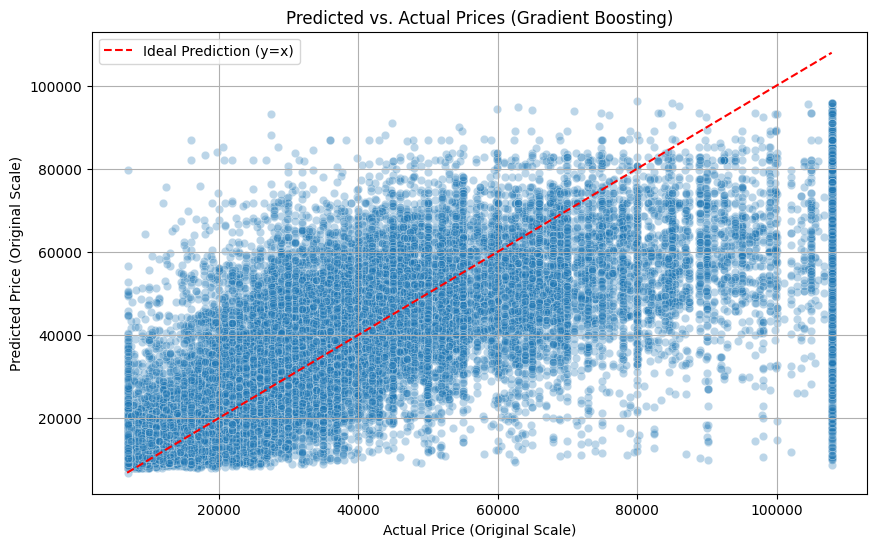

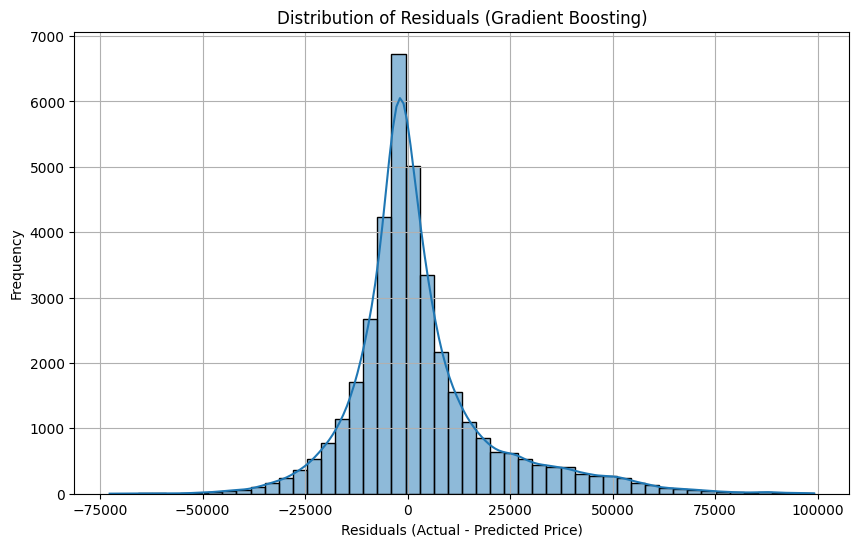

Gráficos para Gradient Boosting generados exitosamente.

Generando gráficos para XGBoost...


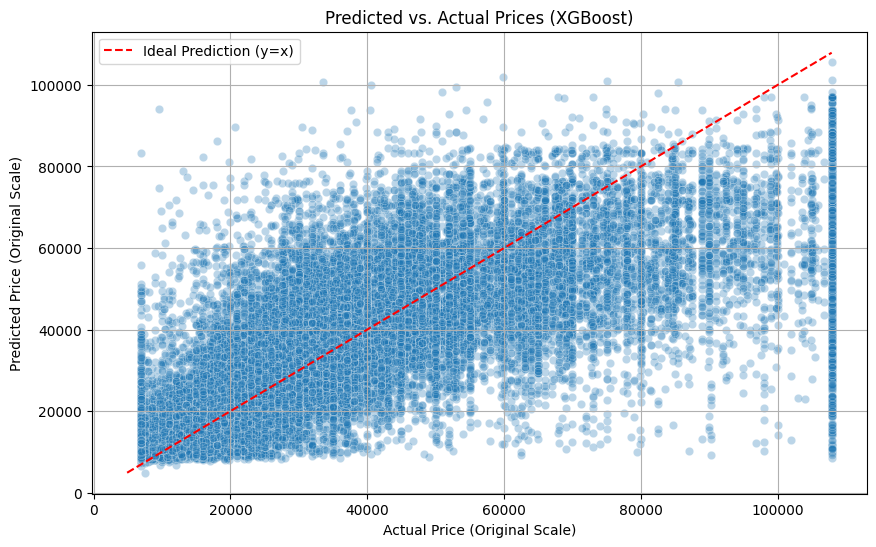

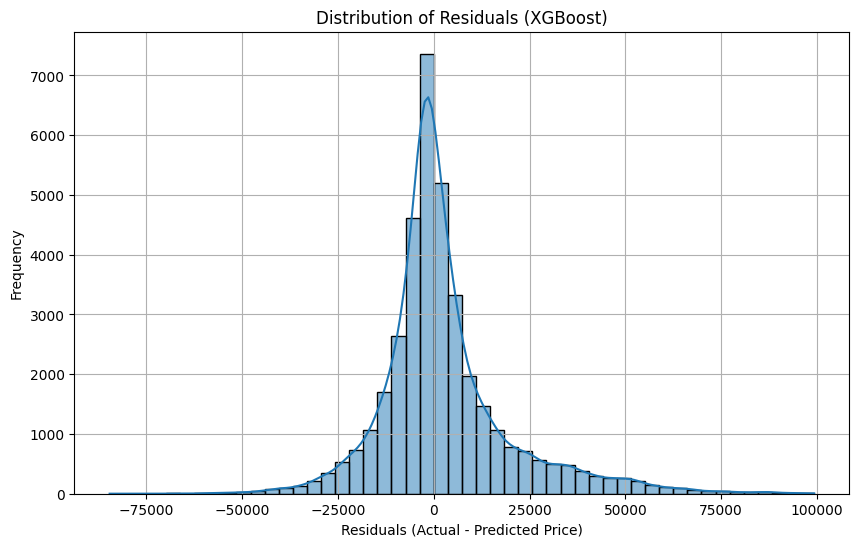

Gráficos para XGBoost generados exitosamente.

Generando gráficos para XGBoost Optimized...


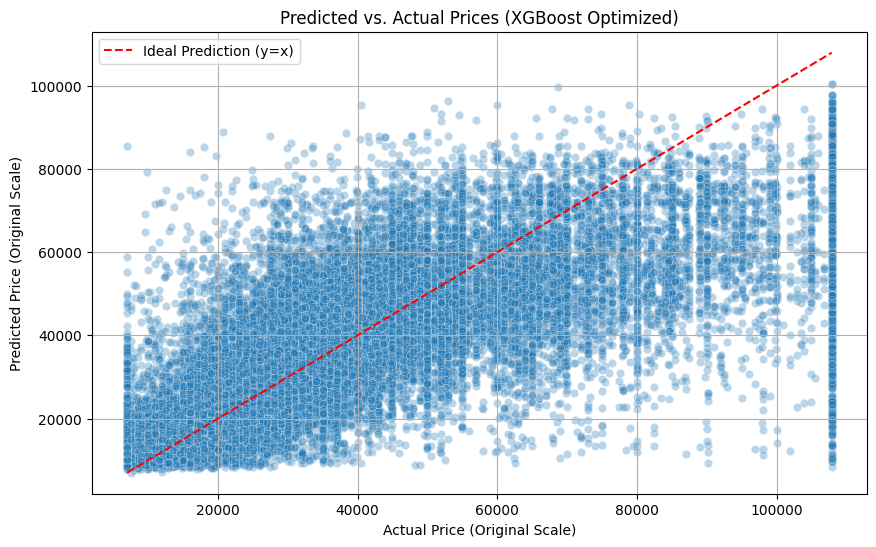

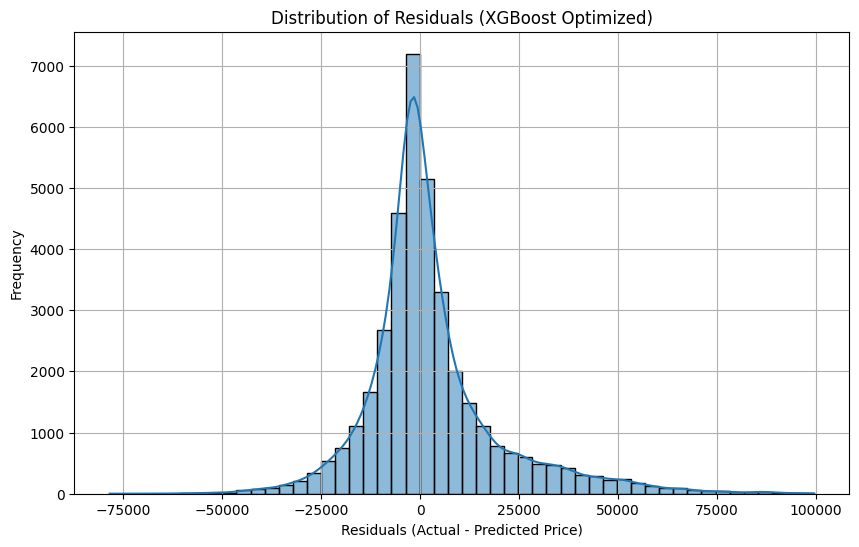

Gráficos para XGBoost Optimized generados exitosamente.


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías de visualización importadas exitosamente.")

# --- 1. Revertir la transformación logarítmica de y_test a la escala original ---
y_test_original = np.expm1(y_test)
print("y_test revertido a la escala original.")

# --- 2. Revertir las predicciones de los modelos a la escala original ---
y_pred_gb_original = np.expm1(y_pred_gb)
print("Predicciones de Gradient Boosting revertidas a la escala original.")

y_pred_xgb_original = np.expm1(y_pred_xgb)
print("Predicciones de XGBoost revertidas a la escala original.")

y_pred_optimized_xgb_original = np.expm1(y_pred_optimized_xgb)
print("Predicciones de XGBoost Optimizado revertidas a la escala original.")

# Diccionario para facilitar la iteración sobre los modelos
models_to_visualize = {
    "Gradient Boosting": y_pred_gb_original,
    "XGBoost": y_pred_xgb_original,
    "XGBoost Optimized": y_pred_optimized_xgb_original
}

# --- 3. Generar gráficos para cada modelo ---
for model_name, y_pred_original in models_to_visualize.items():
    print(f"\nGenerando gráficos para {model_name}...")

    # Gráfico de Dispersión: Predicted vs. Actual
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.3)

    # Añadir línea y=x como referencia
    min_val = min(y_test_original.min(), y_pred_original.min())
    max_val = max(y_test_original.max(), y_pred_original.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction (y=x)')

    plt.title(f'Predicted vs. Actual Prices ({model_name})')
    plt.xlabel('Actual Price (Original Scale)')
    plt.ylabel('Predicted Price (Original Scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de Distribución de Residuos
    residuals = y_test_original - y_pred_original
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title(f'Distribution of Residuals ({model_name})')
    plt.xlabel('Residuals (Actual - Predicted Price)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    print(f"Gráficos para {model_name} generados exitosamente.")